In [1]:
import pandas as pd
import numpy as np

import duckdb

from matplotlib import pyplot as plt
import seaborn as sns

## Mass Loss

### Data Import and Cleaning

In [2]:
mass_df = pd.read_csv("Class_massloss.csv")
mass_df

,Group,Species,Replicate,Treatment,Week,Initial_Mass,Dried_Mass,Proportion
0,1,Red Maple,1,C,0,3.00,2.80,0.933333
1,1,Red Maple,2,C,0,3.00,2.70,0.900000
2,1,Red Maple,3,C,0,2.90,2.70,0.931034
3,1,Red Maple,1,C,2,3.00,1.34,0.446667
4,1,Red Maple,2,C,2,3.00,1.10,0.366667
...,...,...,...,...,...,...,...,...
450,12,Red Oak,2,L,0,3.02,2.92,0.966887
451,12,Red Oak,3,L,0,2.97,3.04,1.023569
452,12,Alder,1,L,0,3.00,2.42,0.806667
453,12,Alder,2,L,0,2.95,2.41,0.816949


In [3]:
mass_w0_df = mass_df.loc[mass_df['Week']==0].copy()
corr_factor = mass_w0_df.loc[mass_w0_df['Treatment']!="L"].copy()
corr_factor['Corr_Factor']=mass_w0_df['Initial_Mass']/mass_w0_df['Dried_Mass']

corr_factor = duckdb.sql("""SELECT "Group", Species, Treatment, AVG(Corr_Factor) AS Corr_Factor
                                FROM corr_factor
                                GROUP BY "Group", Species, Treatment""").df()
corr_factor

,Group,Species,Treatment,Corr_Factor
0,1,Red Maple,C,1.085538
1,1,Wild Grape,C,1.188580
2,2,American Sycamore,C,1.051722
3,2,Black Walnut,C,1.142463
4,3,Red Maple,C,1.088479
5,3,Wild Grape,C,6.501667
6,4,Black Walnut,C,1.117357
7,4,American Sycamore,C,1.094321
8,5,Eastern Cottonwood,C,1.133670
9,5,American Beech,C,1.203257


In [4]:
mass_df = mass_df.merge(corr_factor, how='left', on=['Group','Species','Treatment'])
mass_df['Corr_Factor'] = mass_df['Corr_Factor'].fillna(1)

In [5]:
mass_df['Corr_Proportion'] = mass_df['Proportion']*mass_df['Corr_Factor']

def replace_0(o):
    if o == 0:
        return 0.0000000001
    return o
mass_df['Corr_Proportion'] = mass_df['Corr_Proportion'].apply(replace_0)
mass_df['ln_Corr_Proportion'] = np.log(mass_df['Corr_Proportion'])

mass_df

,Group,Species,Replicate,Treatment,Week,Initial_Mass,Dried_Mass,Proportion,Corr_Factor,Corr_Proportion,ln_Corr_Proportion
0,1,Red Maple,1,C,0,3.00,2.80,0.933333,1.085538,1.013169,0.013083
1,1,Red Maple,2,C,0,3.00,2.70,0.900000,1.085538,0.976984,-0.023285
2,1,Red Maple,3,C,0,2.90,2.70,0.931034,1.085538,1.010673,0.010617
3,1,Red Maple,1,C,2,3.00,1.34,0.446667,1.085538,0.484874,-0.723867
4,1,Red Maple,2,C,2,3.00,1.10,0.366667,1.085538,0.398031,-0.921226
...,...,...,...,...,...,...,...,...,...,...,...
450,12,Red Oak,2,L,0,3.02,2.92,0.966887,1.000000,0.966887,-0.033673
451,12,Red Oak,3,L,0,2.97,3.04,1.023569,1.000000,1.023569,0.023296
452,12,Alder,1,L,0,3.00,2.42,0.806667,1.000000,0.806667,-0.214845
453,12,Alder,2,L,0,2.95,2.41,0.816949,1.000000,0.816949,-0.202178


In [6]:
mass_leachmod_df = mass_df.copy()
mass_leachmod_df['Week'] = mass_leachmod_df['Week'].astype(float)
mass_leachmod_df['Week'].loc[mass_leachmod_df['Treatment']=='L'] = 2/7
mass_leachmod_df['Week'].unique()

/var/folders/6x/szq2cpyn3nlc0q6rcs6pxnp00000gn/T/ipykernel_61843/3716615524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_leachmod_df['Week'].loc[mass_leachmod_df['Treatment']=='L'] = 2/7


array([0.        , 2.        , 4.        , 6.        , 0.28571429])

In [7]:
mass_add0_df = mass_df.loc[(mass_df['Treatment']=='F') | (mass_df['Treatment']=='L')].copy()
mass_add0_df = duckdb.sql("""SELECT Species, Treatment
                                FROM mass_add0_df
                                GROUP BY Species, Treatment""").df()
mass_add0_df['Week']=0
mass_add0_df['Replicate'],mass_add0_df['Initial_Mass'],mass_add0_df['Dried_Mass']=np.nan,np.nan,np.nan
mass_add0_df['Proportion'], mass_add0_df['Corr_Factor'], mass_add0_df['Corr_Proportion'] = 1.000000,1.000000,1.000000
mass_add0_df['ln_Corr_Proportion'] = np.log(mass_add0_df['Corr_Proportion'])

mass_mod_df = pd.concat([mass_leachmod_df, mass_add0_df])

In [8]:
K_df = pd.read_csv("Class_K.csv")
K_df.head()

,Treatment,Group,Species,K
0,C,1,Red Maple,0.0171
1,F,1,Red Maple,0.0133
2,C,1,Wild Grape,0.1358
3,F,1,Wild Grape,0.0354
4,C,2,American Sycamore,-0.0019


### Visualisation

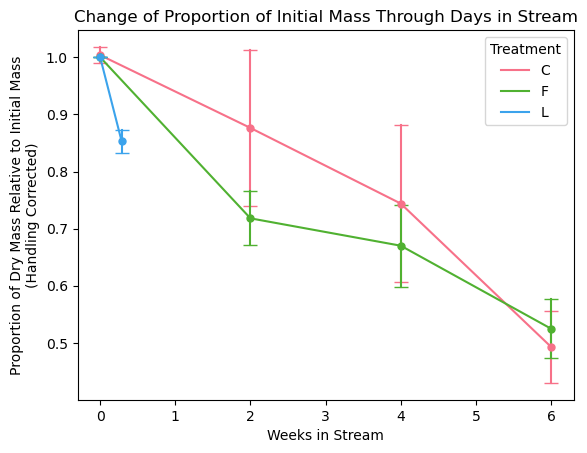

In [9]:
ax = sns.lineplot(data=mass_mod_df, 
                  x='Week', y='Corr_Proportion',
                  hue='Treatment', palette='husl',
                  err_style="bars", errorbar=("se", 2), err_kws=dict(fmt='o', markersize=5, capsize=5))

ax.set(title='Change of Proportion of Initial Mass Through Days in Stream',
       xlabel='Weeks in Stream', ylabel='Proportion of Dry Mass Relative to Initial Mass\n(Handling Corrected)')
plt.show;

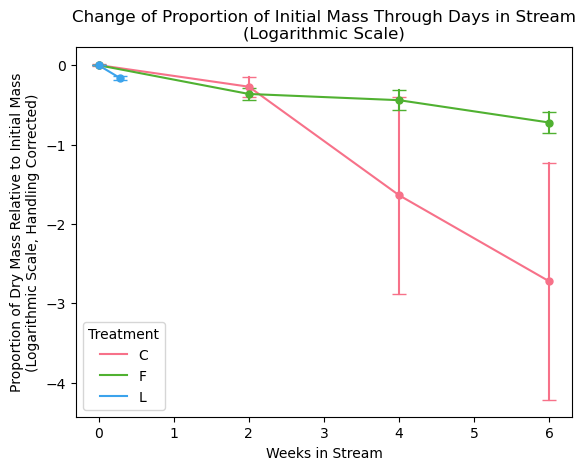

In [10]:
ax = sns.lineplot(data=mass_mod_df, 
                  x='Week', y='ln_Corr_Proportion',
                  hue='Treatment', palette='husl',
                  err_style="bars", errorbar=("se", 2), err_kws=dict(fmt='o', markersize=5, capsize=5))

ax.set(title='Change of Proportion of Initial Mass Through Days in Stream\n(Logarithmic Scale)',
       xlabel='Weeks in Stream', ylabel='Proportion of Dry Mass Relative to Initial Mass\n(Logarithmic Scale, Handling Corrected)')
plt.show;

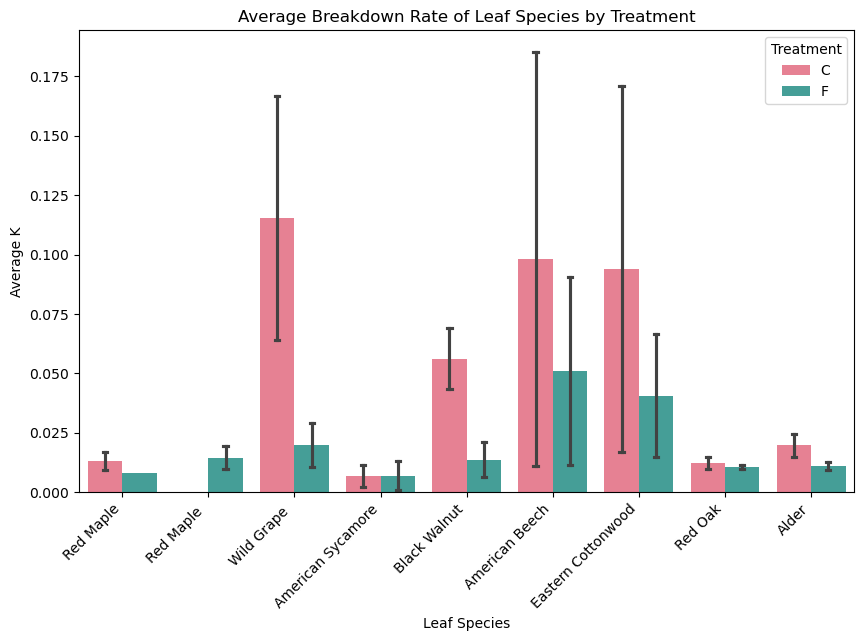

In [11]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the barplot
ax = sns.barplot(data=K_df, 
                 x='Species', y='K', hue='Treatment', 
                 palette='husl', 
                 errorbar=("se"), capsize=0.1)

# Set legend, title, and labels
ax.legend(title='Treatment')
ax.set(title='Average Breakdown Rate of Leaf Species by Treatment',
       xlabel='Leaf Species', ylabel='Average K')

# Get current tick locations and labels
ticks = ax.get_xticks()
ticklabels = [label.get_text() for label in ax.get_xticklabels()]

# Set ticks and rotate and align x-axis labels
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=45, ha='right')

# Show the plot
plt.show()


## Invertebrates

### Data Import and Cleaning

In [12]:
invert_df = pd.read_csv("Class_invert.csv")
invert_df['Count'] = invert_df['Count'].astype(np.int64)

def reclass_treat(o):
    if o == 'c':
        return 'C'
    return o
invert_df['Treatment'] = invert_df['Treatment'].apply(reclass_treat)

def reclass_FFG(o):
    if o == 'GG':
        return 'CG'
    elif o == 'S':
        return 'SC'
    return o
invert_df['FFG'] = invert_df['FFG'].apply(reclass_FFG)

invert_df

,Group,Lab,Leaf_Species,Week,Treatment,Replicate,Order,Family,Genus,FFG,Count
0,3,T,Red Maple,0,C,NaN,Ephemeroptera,Heptageniidae,Macdunnoa,CG,2
1,3,T,Red Maple,2,C,NaN,Trichoptera,Glossosomatidae,Glossosoma,CF,1
2,3,T,Red Maple,4,C,NaN,Trichoptera,Limnephilidae,Goera,CF,1
3,3,T,Red Maple,4,C,NaN,Ephemeroptera,Heptageniidae,Macdunnoa,CG,2
4,2,T,American Sycamore,4,C,1.0,Trichoptera,Philopotamidae,Chimarra,CF,1
...,...,...,...,...,...,...,...,...,...,...,...
491,11,W,Eastern Cottonwood,6,C,3.0,Plecoptera,Leuctridae,Leuctra,SH,8
492,11,W,Eastern Cottonwood,6,C,3.0,Plecoptera,Capniidae,Allocapnia,SH,5
493,11,W,Eastern Cottonwood,6,C,3.0,Diptera,Chironomidae,NaN,CG,1
494,11,W,Eastern Cottonwood,6,C,3.0,Plecoptera,Perlodidae,Isoperla,P,3


In [ ]:
invert_sum_df = duckdb.sql("""SELECT "Group", Leaf_Species, Week, Treatment, Sum(Count) as Count
                                    FROM invert_df
                                    GROUP BY "Group", Leaf_Species, Week, Treatment""").df()
invert_sum_df

In [14]:
invert_unique_df = duckdb.sql("""SELECT "Group", Leaf_Species, Week, Treatment, FFG, Sum(Count) as Count
                                    FROM invert_df
                                    GROUP BY "Group", Leaf_Species, Week, Treatment, FFG""").df()
invert_unique_df

,Group,Leaf_Species,Week,Treatment,FFG,Count
0,3,Red Maple,0,C,CG,2.0
1,3,Red Maple,2,C,CF,1.0
2,3,Red Maple,4,C,CF,1.0
3,3,Red Maple,4,C,CG,2.0
4,2,American Sycamore,4,C,CF,1.0
...,...,...,...,...,...,...
239,8,Black Walnut,2,C,CG,2.0
240,8,Black Walnut,2,C,SC,1.0
241,11,American Beech,6,C,P,6.0
242,9,Red Oak,6,F,P,3.0


In [50]:
invert_genera_richness_df = duckdb.sql("""SELECT Leaf_Species, Treatment, Week, COUNT(DISTINCT Genus) AS Genera_Richness
                                            FROM invert_mod_df
                                            GROUP BY Leaf_Species, Treatment, Week""").df()
invert_genera_richness_df

,Leaf_Species,Treatment,Week,Genera_Richness
0,Red Maple,C,0,1
1,Red Maple,C,2,8
2,Red Maple,C,4,13
3,American Sycamore,C,4,8
4,American Sycamore,C,2,13
5,Black Walnut,C,2,13
6,American Sycamore,C,6,18
7,Black Walnut,C,6,8
8,American Sycamore,F,2,3
9,Black Walnut,F,2,5


### Visualisation

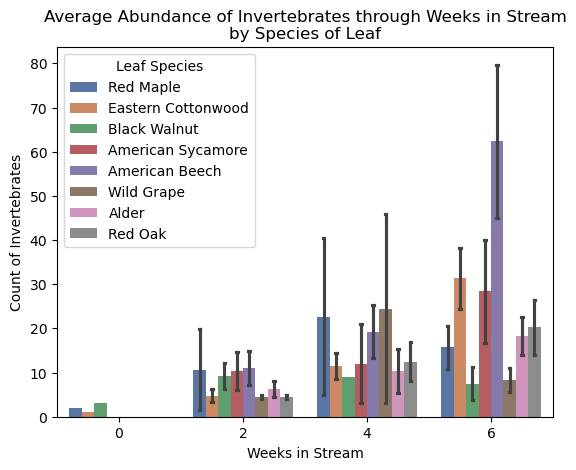

In [15]:
ax = sns.barplot(data=invert_sum_df, 
                 x='Week', y='Count', hue='Leaf_Species', 
                 palette='deep', 
                 errorbar=("se"), capsize=0.1
                 #err_kws={'fmt': 'o', 'markersize': 8, 'capsize': 5}
                )
ax.legend(title='Leaf Species')
ax.set(title='Average Abundance of Invertebrates through Weeks in Stream\nby Species of Leaf',
       xlabel='Weeks in Stream', ylabel='Count of Invertebrates')
plt.show()

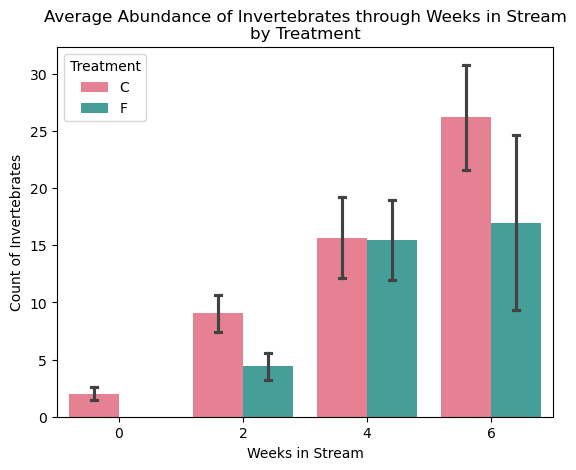

In [16]:
ax = sns.barplot(data=invert_sum_df, 
                 x='Week', y='Count', hue='Treatment', 
                 palette='husl', 
                 errorbar=("se"),capsize=0.1 
                 #estimator='sum', errorbar=None
                )
ax.legend(title='Treatment')
ax.set(title='Average Abundance of Invertebrates through Weeks in Stream\nby Treatment',
       xlabel='Weeks in Stream', ylabel='Count of Invertebrates')
plt.show()

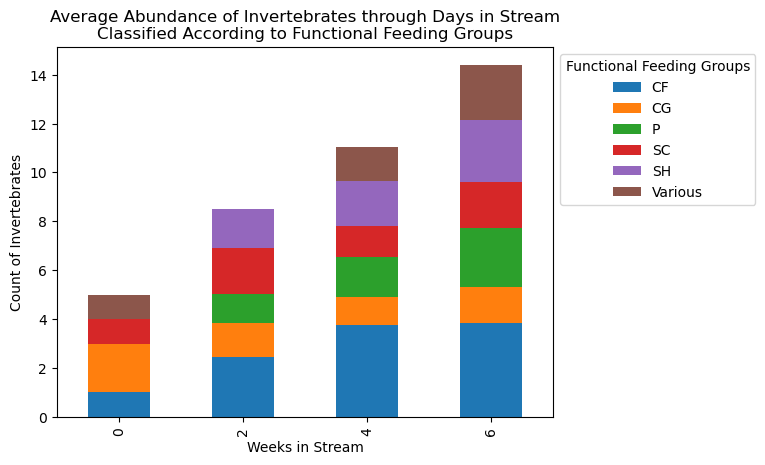

In [28]:
data = invert_df[invert_df['Treatment']=='C']

# Create a pivot table for the data
pivot_data = data.pivot_table(index='Week', columns='FFG', values='Count', fill_value=0)

# Plotting
ax = pivot_data.plot(kind='bar', stacked=True)

# Set titles and labels
ax.set_title('Average Abundance of Invertebrates through Days in Stream\nClassified According to Functional Feeding Groups')
ax.set_xlabel('Weeks in Stream')
ax.set_ylabel('Count of Invertebrates')
ax.legend(title='Functional Feeding Groups', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

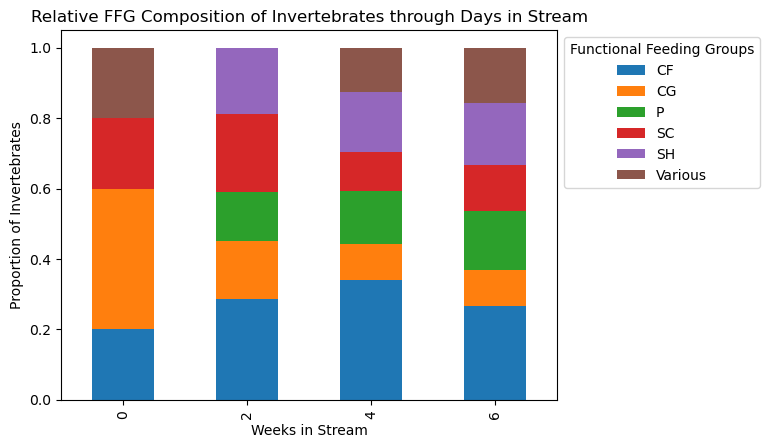

In [31]:
# Create a pivot table for the data
pivot_data = data.pivot_table(index='Week', columns='FFG', values='Count', fill_value=0)

# Normalize the data to get proportions
pivot_data_normalized = pivot_data.div(pivot_data.sum(axis=1), axis=0)

# Plotting
ax = pivot_data_normalized.plot(kind='bar', stacked=True)

# Set titles and labels
ax.set_title('Relative FFG Composition of Invertebrates through Days in Stream')
ax.set_xlabel('Weeks in Stream')
ax.set_ylabel('Proportion of Invertebrates')

# Move the legend to the side of the graph
ax.legend(title='Functional Feeding Groups', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

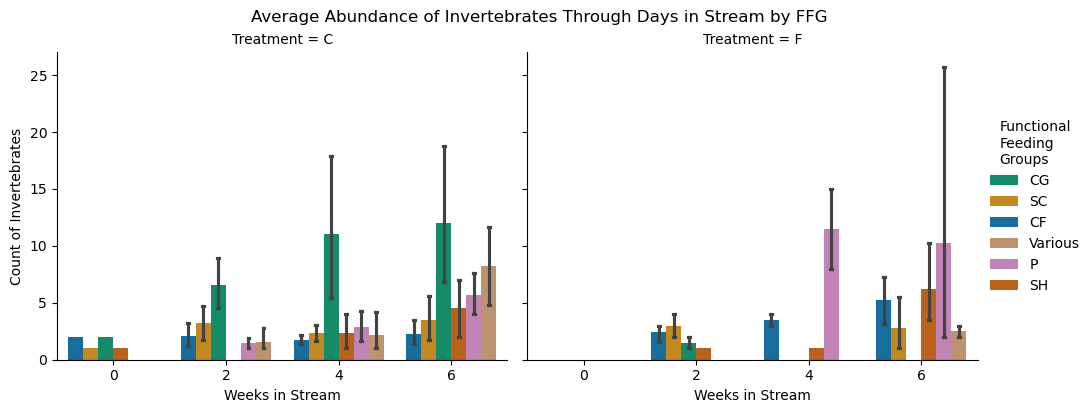

In [18]:
#ffg_order = sorted(invert_unique_df['FFG'].unique())
week_order = sorted(invert_df['Week'].unique())

g = sns.FacetGrid(data=invert_unique_df, col='Treatment', height=4, aspect=1.25 #, ylim=(0,40), xlim=(0,6)
                 )
g.map_dataframe(sns.barplot, x='Week', y='Count', hue='FFG', palette='colorblind', order=week_order, capsize=0.1)

g.tight_layout()
g.set_axis_labels("Weeks in Stream", "Count of Invertebrates")
g.add_legend(title='Functional\nFeeding\nGroups')
plt.suptitle("Average Abundance of Invertebrates Through Days in Stream by FFG", y=1.02)

# Displaying the plots
plt.show()

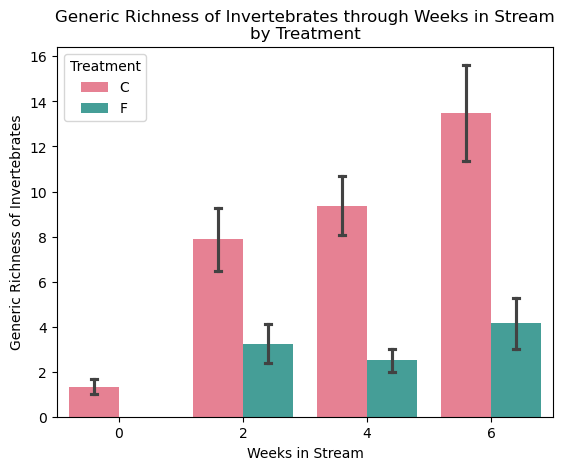

In [38]:
ax = sns.barplot(data=invert_genera_richness_df, 
                 x='Week', y='Genera_Richness', hue='Treatment', 
                 palette='husl', 
                 errorbar=("se"),capsize=0.1 
                 #estimator='sum', errorbar=None
                )
ax.legend(title='Treatment')
ax.set(title='Generic Richness of Invertebrates through Weeks in Stream\nby Treatment',
       xlabel='Weeks in Stream', ylabel='Generic Richness of Invertebrates')
plt.show()

Text(0.5, 1.02, 'Generic Richness of Invertebrates Through Days in Stream by Treatment')

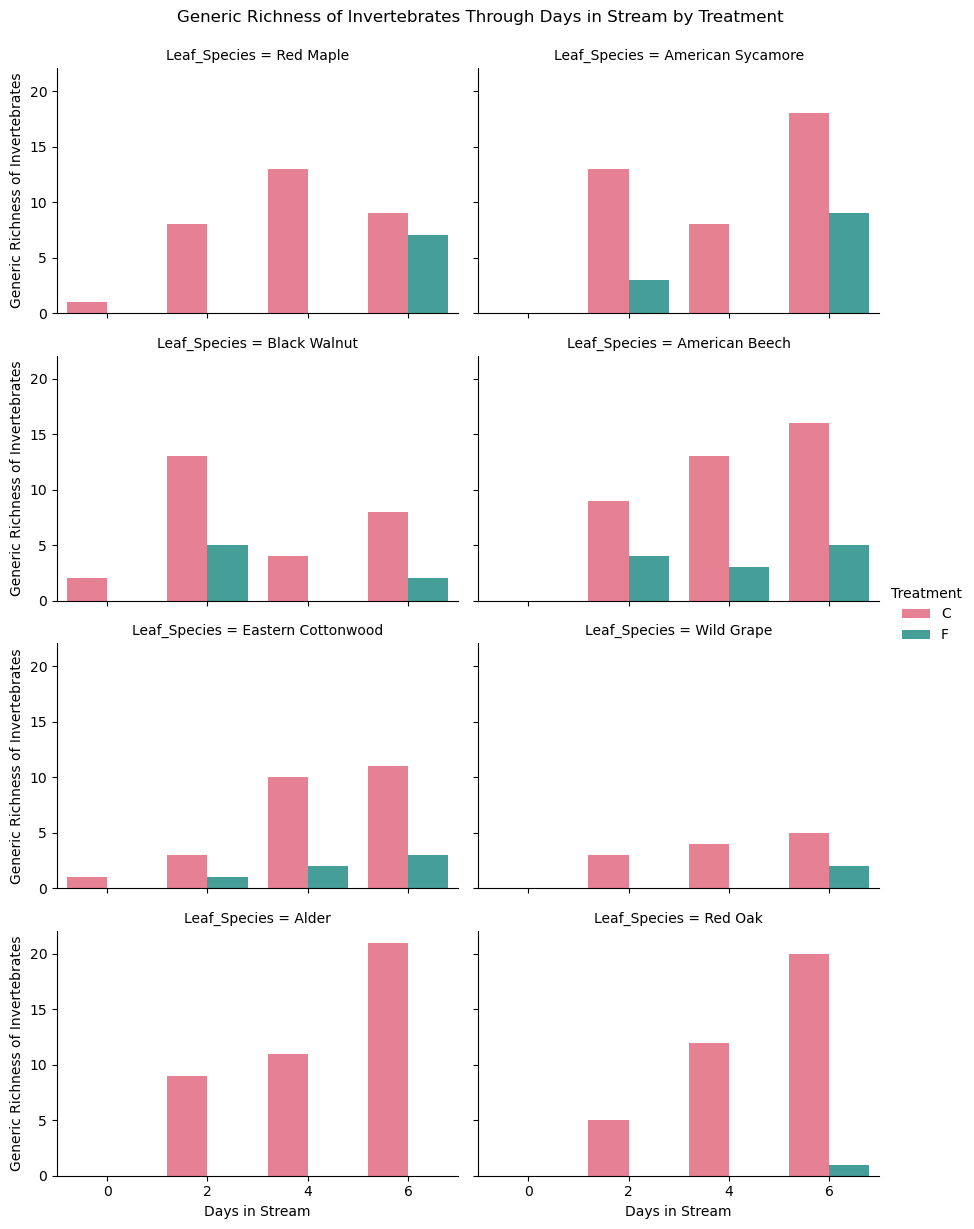

In [52]:
g = sns.FacetGrid(data=invert_genera_richness_df, col='Leaf_Species', col_wrap=2, height=3, aspect=1.5)
g.map_dataframe(sns.barplot, x='Week', y='Genera_Richness', hue='Treatment', hue_order=['C', 'F'], palette='husl')

g.tight_layout()
g.set_axis_labels("Days in Stream", "Generic Richness of Invertebrates")
g.add_legend(title='Treatment')
plt.suptitle("Generic Richness of Invertebrates Through Days in Stream by Treatment", y=1.02)